# uv-chains with Association

In [1]:
from feos.si import *
from feos.eos import *
from feos.uvtheory import *
#from feos.eos.estimator import *

import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import seaborn as sns
import numpy as np

colors = sns.color_palette("winter", 10)
sns.set_context("talk")
sns.set_style("ticks")

from feos.ideal_gas import JobackParameters

In [2]:
# uv-Parameters from fit to DDB data (liquid densities, vapor pressures)
pr = PureRecord.from_json_str("""{
        "identifier": {
            "cas": "64-17-5",
            "name": "ethanol",
            "smiles": "CCO",
            "inchi": "InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3"
        },
        "molarweight": 46.042,
        "model_record": {
            "m": 1.53604734,
            "rep": 12,
            "att": 6,
            "sigma": 3.78204555,
            "epsilon_k": 2.63385160e+02,
            "kappa_ab": 9.04054336e-03,
            "epsilon_k_ab": 2.74689714e+03,
            "na": 1.0,
            "nb": 1.0
        }
    }""")
parameters = JobackParameters.from_json_segments(["ethanol"], "reference_data/gc_substances.json", "reference_data/sauer2014_homo_joback.json")
MW = pr.molarweight * GRAM / MOL
uv_ethanol = EquationOfState.uvtheory(UVParameters.new_pure(pr), perturbation=Perturbation.BarkerHenderson).joback(parameters)




In [3]:
vle = PhaseDiagram.pure(uv_ethanol, 250*KELVIN, 51)

Text(0.5, 0, '$\\rho$ / (kg/m³)')

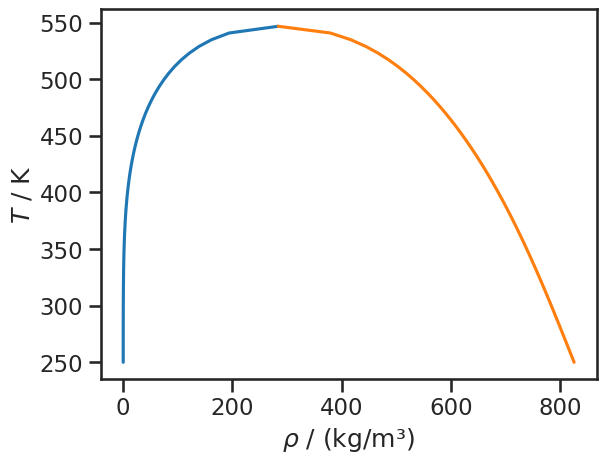

In [4]:
plt.plot(vle.vapor.density * MW / (KILOGRAM / METER**3), vle.vapor.temperature / KELVIN)
plt.plot(vle.liquid.density * MW / (KILOGRAM / METER**3), vle.liquid.temperature / KELVIN)
plt.ylabel('$T$ / K')
plt.xlabel('$\\rho$ / (kg/m³)')

In [5]:
tvec = np.linspace(200, 540, 80)
dhv_uv = []
for t in tvec:
    vle = PhaseEquilibrium.pure(uv_ethanol, t*KELVIN)
    dhv_uv.append((vle.vapor.molar_enthalpy() - vle.liquid.molar_enthalpy()) / (KILO * JOULE / MOL) )
    

Text(0.5, 1.0, 'Ethanol')

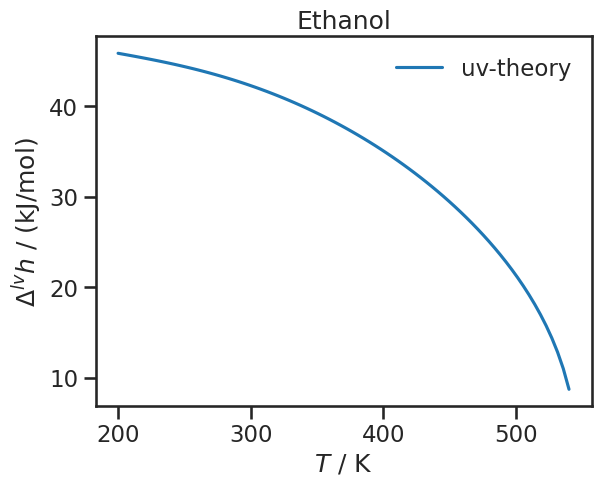

In [7]:
plt.plot(tvec, dhv_uv, '-', label='uv-theory')
plt.xlabel('$T$ / K')
plt.ylabel('$\\Delta^{lv} h$ / (kJ/mol)')
plt.legend(frameon=False)
plt.title('Ethanol')

In [8]:
from feos.pcsaft import *
parameters = PcSaftParameters.from_json(
    ['ethanol'], 
    '../../parameters/pcsaft/rehner2020.json'
)
parameters
parameters_saft = JobackParameters.from_json_segments(["ethanol"], "reference_data/gc_substances.json", "reference_data/sauer2014_homo_joback.json")
#MW = pr.molarweight * GRAM / MOL
pcsaft = EquationOfState.pcsaft(parameters).joback(parameters_saft)

In [9]:
tvec = np.linspace(200, 520, 80)
dhv_saft = []
for t in tvec:
    vle = PhaseEquilibrium.pure(pcsaft, t*KELVIN)
    dhv_saft.append((vle.vapor.molar_enthalpy() - vle.liquid.molar_enthalpy()) / (KILO * JOULE / MOL) )

Text(0.5, 1.0, 'Ethanol')

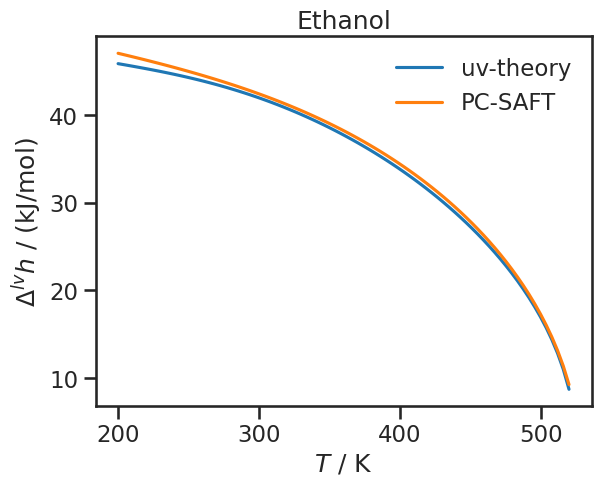

In [10]:
plt.plot(tvec, dhv_uv, '-', label='uv-theory')
plt.plot(tvec, dhv_saft, '-', label='PC-SAFT')
plt.xlabel('$T$ / K')
plt.ylabel('$\\Delta^{lv} h$ / (kJ/mol)')
plt.legend(frameon=False)
plt.title('Ethanol')